<a href="https://colab.research.google.com/github/gulabpatel/Graph_Neural_Network/blob/main/05.1%3A%20GNN_XAI(GNNExplainer).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to explain Graph Neural Networks using GNNExplainer

Video walkthrough the code : https://www.youtube.com/watch?v=aFnlmzFh4iQ

## Install Pytorch Geometric

In [1]:
import torch
torch.manual_seed(42)
from IPython.display import clear_output 
torch_version = torch.__version__
print("Torch version: ", torch_version)
pytorch_version = f"torch-{torch.__version__}.html"
!pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install torch-geometric
clear_output()
print("Done.")

Done.


## Twitch Streamer Dataset

- Twitch user-user networks of gamers who stream in a certain language
- Nodes are the users themselves and the links are mutual friendships between them
- These social networks were collected in May 2018

In [2]:
from torch_geometric.datasets import Twitch
# Dataset source: https://github.com/benedekrozemberczki/datasets#twitch-social-networks
graph = Twitch(root=".", name="EN")[0]
graph

Processing...
Done!


Data(x=[7126, 128], edge_index=[2, 77774], y=[7126])

### The node features 
- Extracted based on the games played and liked, location and streaming habits
- These are embeddings, which cannot be interpreted directly

In [3]:
graph.x

tensor([[-0.2367, -0.2307, -0.1605,  ...,  1.3203, -0.2558, -0.1839],
        [-0.2367, -0.2150, -0.1605,  ...,  1.3572, -0.2538, -0.1685],
        [-0.2367, -0.2043, -0.0994,  ..., -0.6348, -0.2558, -0.1839],
        ...,
        [-0.2193, -0.2307, -0.1605,  ..., -0.6348, -0.2558, -0.1839],
        [-0.2367, -0.2307, -0.1605,  ..., -0.6348, -0.2558, -0.1733],
        [ 4.6088, -0.2307, -0.1605,  ...,  1.2370, -0.2558, -0.1839]])

### A binary node classification task
- Predict if a streamer uses explicit language

In [4]:
graph.y

tensor([1, 0, 1,  ..., 0, 0, 1])

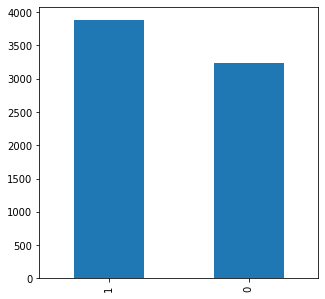

In [5]:
import pandas as pd
from pylab import rcParams
rcParams['figure.figsize'] = 5, 5
df = pd.DataFrame(graph.y.numpy(), columns=["explicit_language"])
df['explicit_language'].value_counts().plot(kind='bar')

## A simple model

In [6]:
from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import GATConv
embedding_size = 128

class GNN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GNN, self).__init__()

        # GCN layers
        self.initial_conv = GATConv(graph.num_features, embedding_size)
        self.conv1 = GATConv(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(embedding_size, 1)

    def forward(self, x, edge_index):
        emb = F.relu(self.initial_conv(x, edge_index))
        emb = F.relu(self.conv1(emb, edge_index))
        return self.out(emb)

model = GNN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GNN(
  (initial_conv): GATConv(128, 128, heads=1)
  (conv1): GATConv(128, 128, heads=1)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  33665


### Add train and test masks
- Alternative: Transform + RandomNodeSplit

In [7]:
# Add train and test masks
num_nodes = graph.x.shape[0]
ones = torch.ones(num_nodes)
ones[4000:] = 0
graph.train_mask = ones.bool()
graph.test_mask = ~graph.train_mask.bool()

print("Train nodes: ", sum(graph.train_mask))
print("Test nodes: ", sum(graph.test_mask))

Train nodes:  tensor(4000)
Test nodes:  tensor(3126)


In [8]:
graph.train_mask

tensor([ True,  True,  True,  ..., False, False, False])

In [9]:
graph.test_mask

tensor([False, False, False,  ...,  True,  True,  True])

## Training

- We train the model with the full graph, so batch size = 1
- For large graphs its also possible to train in batches, by using the NeighborSampler
- This is a transductive setup, as all nodes are used during training
- Inductive training can be achieved using GraphSAGE


In [10]:
# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = GNN()
model = model.to(device)
graph = graph.to(device)

# Loss function
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)  


def train():
      model.train()
      optimizer.zero_grad() 
      out = model(graph.x, graph.edge_index)  
      preds = out[graph.train_mask]
      targets = torch.unsqueeze(graph.y[graph.train_mask], 1)
      loss = loss_fn(preds.float(), targets.float())  
      loss.backward() 
      optimizer.step()
      return loss

def test():
      model.eval()
      optimizer.zero_grad() 
      out = model(graph.x, graph.edge_index)  
      preds = out[graph.test_mask]
      targets = torch.unsqueeze(graph.y[graph.test_mask], 1)
      loss = loss_fn(preds.float(), targets.float())  
      return loss

for epoch in range(0, 800):
    tr_loss = train()
    if epoch % 100 == 0:
      loss = test()
      print(f'Epoch: {epoch:03d}, Test loss: {loss:.4f} | Train loss: {tr_loss:.4f}')

Epoch: 000, Test loss: 0.6880 | Train loss: 0.6885
Epoch: 100, Test loss: 0.6843 | Train loss: 0.6822
Epoch: 200, Test loss: 0.6824 | Train loss: 0.6774
Epoch: 300, Test loss: 0.6809 | Train loss: 0.6737
Epoch: 400, Test loss: 0.6796 | Train loss: 0.6700
Epoch: 500, Test loss: 0.6785 | Train loss: 0.6658
Epoch: 600, Test loss: 0.6778 | Train loss: 0.6614
Epoch: 700, Test loss: 0.6776 | Train loss: 0.6568


In [11]:
from sklearn.metrics import roc_auc_score

df = pd.DataFrame()
# Model predictions'
out = torch.sigmoid(model(graph.x, graph.edge_index))
df["preds"] = out[graph.test_mask].round().int().cpu().detach().numpy().squeeze()
df["prob"] = out[graph.test_mask].cpu().detach().numpy().squeeze().round(2)

# Groundtruth
df["gt"] = graph.y[graph.test_mask].cpu().detach().numpy().squeeze()

print("Test ROC: ", roc_auc_score(df["gt"], df["preds"]))
df.head(10)

Test ROC:  0.5687391641761471


,preds,prob,gt
0,0,0.49,0
1,1,0.63,1
2,1,0.54,1
3,0,0.45,0
4,1,0.57,1
5,0,0.49,0
6,1,0.52,1
7,0,0.48,0
8,1,0.69,1
9,1,0.57,1


## Explaining the predictions

In [12]:
from torch_geometric.nn import GNNExplainer
# Initialize explainer
explainer = GNNExplainer(model, epochs=200, return_type='log_prob')

# Explain node
node_idx = 7
node_feat_mask, edge_mask = explainer.explain_node(node_idx, graph.x, graph.edge_index)
print("Size of explanation: ", sum(edge_mask > 0))

Explain node 7: 100%|██████████| 200/200 [00:02<00:00, 82.58it/s] 


Size of explanation:  tensor(25, device='cuda:0')


In [13]:
print("Node features: ", graph.x[node_idx])
print("Node label: ",  df["gt"][node_idx])
print("Node prediction: ",  df["preds"][node_idx])

Node features:  tensor([-0.2367, -0.1935,  3.7567, -0.2128, -0.2124,  5.4706, -0.5386, -0.4115,
        -0.1622,  0.2116, -0.1529, -0.3459, -0.1957, -0.2217, -0.4750, -0.2006,
        -0.4221, -0.2727, -0.4964, -0.2263, -0.2821, -0.2192, -0.2268, -0.2027,
         1.0373, -0.0218, -0.2800, -0.2361, -0.2226, -0.2057, -0.3231, -0.1938,
         3.7738, -0.2022, -0.5585,  4.2744, -0.0594, -0.3480, -0.3727, -0.4935,
        -0.2020, -0.2183,  1.8572, -0.0779, -0.2263, -0.1528,  2.0653, -0.4668,
        -0.2193, -0.1163,  6.3437, -0.2100, -0.6597, -0.2962, -0.2531,  1.8709,
        -0.2680, -0.2187,  0.7300, -0.2951, -0.2064, -0.1886, -0.2112, -0.2915,
        -0.2250,  3.5988, -0.3386,  4.3039, -0.2275,  0.1154, -0.2643,  2.2388,
         0.1718, -0.2528,  2.2578, -0.2046,  3.3064, -0.4842,  3.8121, -0.2549,
        -0.3419, -0.1695, -0.3224, -0.2822, -0.3064, -0.2185, -0.2841, -0.4582,
        -0.2062, -0.2791, -0.2172, -0.5902, -0.6998, -0.1862, -0.1884, -0.1220,
        -0.3154, -0.2393

## Create visualizations

In [14]:
# Show shape of masks
print(node_feat_mask.shape)
print(edge_mask.shape)

torch.Size([128])
torch.Size([77774])


### The size of the following plot depends on the depth of the GNN!
- Colors are edge labels
- Greyed-out edges have an impact, but very low (< 0.1)

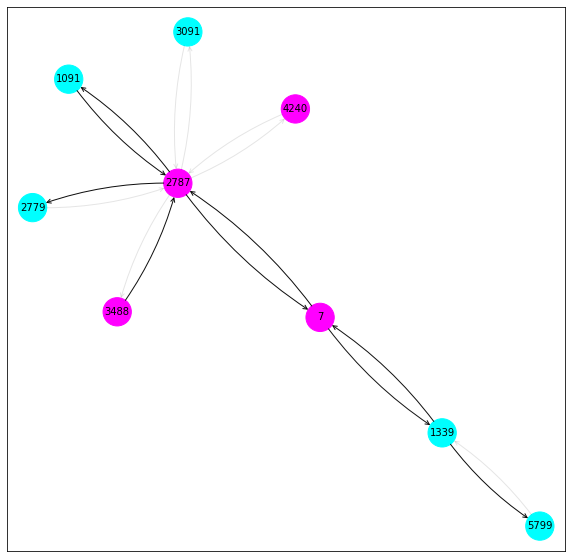

In [15]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

# Visualize result
ax, G = explainer.visualize_subgraph(node_idx, graph.edge_index, edge_mask, y=graph.y)
plt.show()

#### For further details: https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/models/gnn_explainer.html